In [28]:
#LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from sklearn.metrics import r2_score,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix,precision_score,recall_score,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from scipy.stats import norm, skew
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Lasso,Ridge,BayesianRidge,ElasticNet,HuberRegressor,LinearRegression,LogisticRegression,SGDRegressor
import warnings
warnings.filterwarnings('ignore')
from pycaret.regression import *

In [29]:
# READING
train = pd.read_csv("D:/R/House Prices kaggle/train.csv")
test = pd.read_csv("D:/R/House Prices kaggle/test.csv")

In [30]:
# BINDING
master=pd.concat([train,test],ignore_index=True)
print(train.shape,test.shape,master.shape)
master.head()

(1460, 81) (1459, 80) (2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


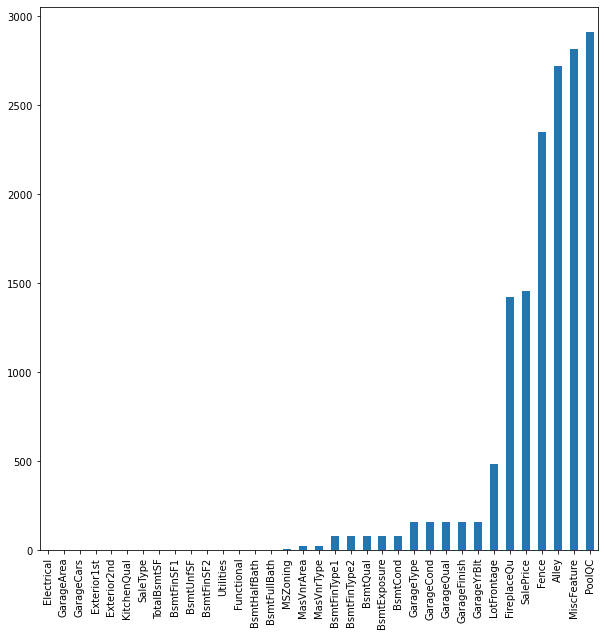

In [31]:
#missing values
fig = plt.figure(figsize=(10,10))
missing = master.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [32]:
## SEPEARTION CATEGORY VS NUMERIC

cat=['MSZoning','Street','Alley','LotShape','LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2','Heating',
       'HeatingQC', 'CentralAir', 'Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual',
       'GarageCond', 'PavedDrive','PoolQC','MSSubClass',
       'Fence', 'MiscFeature','SaleType','SaleCondition','OverallQual', 'OverallCond','GarageCars']


num=['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF','LowQualFinSF','GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath','1stFlrSF', '2ndFlrSF','WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','SalePrice']



final=master[num+cat]


In [33]:
target_var_name = 'SalePrice'
target_var = pd.DataFrame(final[target_var_name]).set_index(final.index)
final.drop(target_var_name, axis=1, inplace=True)
target_var

,SalePrice
0,208500.0
1,181500.0
2,223500.0
3,140000.0
4,250000.0
...,...
2914,NaN
2915,NaN
2916,NaN
2917,NaN


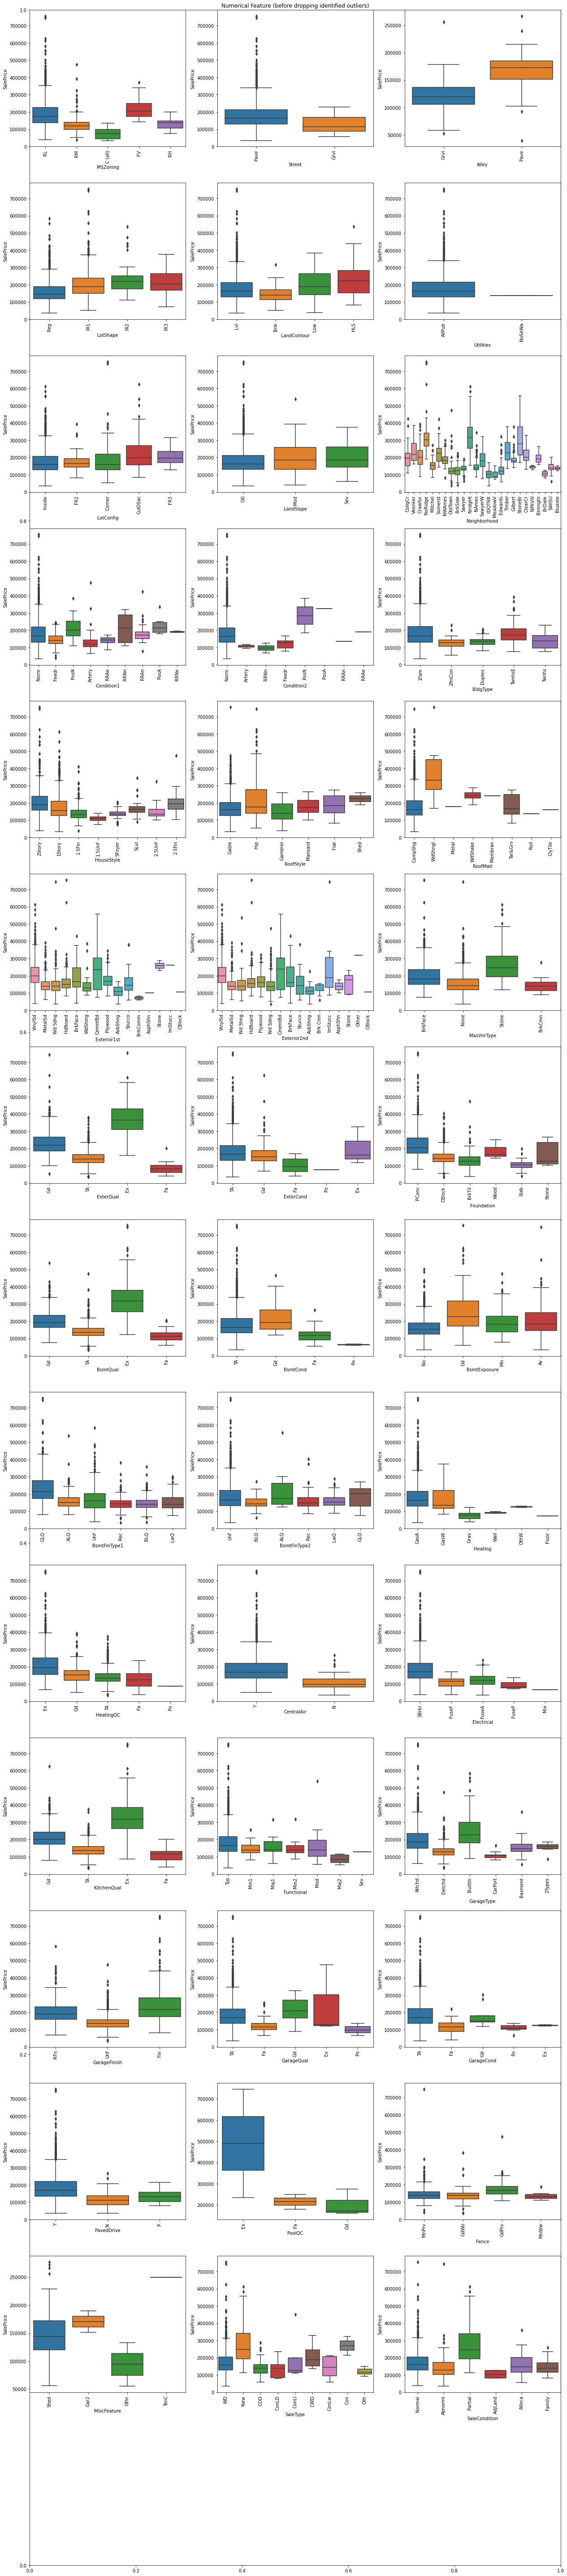

In [34]:
cat_feature = final.select_dtypes(include=['object']).columns
home_data_cat_feature = final[cat_feature]
fig = plt.figure(figsize=(18,80))
plt.title('Numerical Feature (before dropping identified outliers)')
for i in range(len(home_data_cat_feature.columns)):
    fig.add_subplot(15,3,i+1)
    sns.boxplot(x=home_data_cat_feature.iloc[:,i],y=target_var['SalePrice'])
    plt.xlabel(home_data_cat_feature.columns[i])
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [35]:
         ### GIVEN IN DATA DICTIONRAY THAT NA MEANS None FOR SOME VARIABLES
                  ## IMPUTE 2-3 NA WITH mode i.e For some Categorical Variables##
                  ### IMPUTE 4-5 NA i.e Numeric some with mean some with median
### IMPUTE GARAGE BUILD 0 As all are garage variable are no and zero so imput garge yr built 0 means not built###
## IMPUTE LOT FRONTAGE WITH RESPECT TO ITS NEIGHBOURHOOD as since area of each street connected to....
##                                         house property likely have same area with respect to its neigbour

#1.MSVNR AND MIS FEATURE.....

ln={'MiscFeature','MasVnrType','Alley','PoolQC','Fence'}
for i in ln:
    master[i].fillna('None',inplace=True)
    
#DEFINING DEICTIONARIES 
Bsmt = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
Grg = ['GarageType','GarageFinish','GarageQual','GarageCond']

#2.BSMTS
for col in Bsmt:
    master[col].fillna('No_Bsmt',inplace=True)
    
#3.GRGES    
for col in Grg:
    master[col].fillna('No_Grg',inplace=True)    
    

#4.FIRE PLACES
master['FireplaceQu'] = master['FireplaceQu'].fillna('NotAvailable')

#5.IMPUTE WITH MEDIAN or 0  DUE TO 1-3 NA IN EACH VARIABLRS AS THESE ARE IN CATEGORIES 

tt={'BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','BsmtUnfSF'}
for c in tt:
    master[c] = master[c].fillna(0)

    
    
#6.IMPUTE WITH MODE WHICH LEADS TO HIGH FREQUENCY VARIABLES 

ts={'Exterior1st','Exterior2nd','KitchenQual','Functional','MSZoning','Utilities','Electrical','SaleType','MSZoning'}
for i in ts:
    master[i].fillna(master[i].mode,inplace=True)
 
       
#7.MSVNR AREA # DUE TO 0 MEAN AND 0 MEDIAN
master.MasVnrArea = master.MasVnrArea.fillna(0)

    
#8.Garages   

for col in ('GarageArea', 'GarageCars'):
    master[col] = master[col].fillna(0)

#9.LOT FRONTAGE

master["LotFrontage"] = master.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))


#OUTLIER HANDLER
def out_quant(x):
    d=np.arange(0,1,0.01)
    ds=x.quantile(d)
    return ds



#10.GARAGE YR BLT
master.GarageYrBlt = KNNImputer(n_neighbors=55, weights="uniform").fit_transform(master[['GarageYrBlt']])

In [36]:
ds=['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual','ExterCond','HeatingQC', 'PoolQC', 
     'KitchenQual','BsmtFinType1', 'BsmtFinType2','Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 
     'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass','HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st',
     'OverallCond','MSZoning','LotShape','LandContour', 'Utilities', 'LotConfig','Exterior2nd', 'MasVnrType','Foundation', 
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','GarageType','GarageFinish','Heating','Electrical',
    'BsmtExposure','MiscFeature','SaleType','SaleCondition']
      


for i in ds:
    master[i]=master[i].astype(str)


for col in ds:
    lbl_enc = LabelEncoder() 
    master[col] = lbl_enc.fit_transform(master[col])

In [37]:
master.GrLivArea.loc[master.GrLivArea > 2935.72]=2935.72
master.LotFrontage.loc[master.LotFrontage >  132.64]= 132.64
master.MiscVal.loc[master.MiscVal >982.0]=982.0
master.TotalBsmtSF.loc[master.TotalBsmtSF >  2198.20]= 2198.20
master['1stFlrSF'].loc[master['1stFlrSF'] > 2288.02]=2288.02
master.BsmtFinSF2.loc[master.BsmtFinSF2 >  874.64]=  874.64
master.BsmtFinSF1.loc[master.BsmtFinSF1 > 1635.28]=1635.28
master.LotArea.loc[master.LotArea > 33038.64]=33038.64
master.LowQualFinSF.loc[master.LowQualFinSF > 153.84]=153.84
master.BsmtUnfSF.loc[master.BsmtUnfSF > 1776.46]=1776.46
master.GarageArea.loc[master.GarageArea > 1019.46]=1019.46
master.ScreenPorch.loc[master.ScreenPorch > 259.82]=259.82
master.MasVnrArea.loc[master.MasVnrArea > 770.46]=770.46
master.TotRmsAbvGrd.loc[master.TotRmsAbvGrd > 11.0]=11.0
master.WoodDeckSF.loc[master.WoodDeckSF > 500.82]=500.82
master['3SsnPorch'].loc[master['3SsnPorch'] > 144.0]=144.0
master.EnclosedPorch.loc[master.EnclosedPorch > 264.00]=264.00
master.OpenPorchSF.loc[master.OpenPorchSF > 284.46]=284.46
master.BsmtUnfSF.loc[master.BsmtUnfSF > 1776.46]=1776.46
master['2ndFlrSF'].loc[master['2ndFlrSF'] > 1400.20]=1400.20
master['PoolArea'].loc[master['PoolArea'] > 0]=0
master['GarageYrBlt'].loc[master['GarageYrBlt'] > 2009.0]=2009.0
master['GarageCars'].loc[master['GarageCars'] > 3.0]=3.0
master['Heating'].loc[master['Heating'] > 2.0]=2.0


In [38]:
#NUMERIC VARIABLES
master['Lot_Length']=master['LotArea'] / master['LotFrontage']
master['Life_Sold']=master['YrSold'] - master['YearBuilt']
master['Yr_Sin_Radd']=master['YrSold'] - master['YearRemodAdd']
master['Total_SF'] = master['TotalBsmtSF'] + master['1stFlrSF'] + master['2ndFlrSF']
master['Total_Area']=master['GarageArea'] + master['LotArea'] + master['GrLivArea'] + master['MasVnrArea'] + master['PoolArea']
master['Total_Sf_Outdoor']=master['WoodDeckSF'] + master['OpenPorchSF']
master['Total_PorchS.F']=(master['OpenPorchSF']+master['3SsnPorch']+master['EnclosedPorch']+master['ScreenPorch']+master['WoodDeckSF'])
master['Total_Bathrooms'] = (master['FullBath'] + (0.5 * master['HalfBath']) +
                               master['BsmtFullBath'] + (0.5 * master['BsmtHalfBath']))
master['Yr_Blt_Rmd']=master['YearBuilt']+master['YearRemodAdd']
master['Life_Rmd_Sold']=master['YrSold']-master['Yr_Blt_Rmd']
master['Tot_Home_Overall']=master['OverallQual']+master['OverallCond']
master['Tot_Cond']=master['Condition1']+master['Condition2']
master['Total_sqr_footage'] = (master['BsmtFinSF1'] + master['BsmtFinSF2'] + master['1stFlrSF'] + master['2ndFlrSF'])

#CATEGORICAL VARIABLES
master['HasGarage']=master['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
master['HasMasvn']=master['MasVnrArea'].apply(lambda x:1 if x > 0 else 0)
master['HasBsmt']=master['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
master['Has2ndfloor'] = master['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
master['HasFirePlace'] = master['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
master['old_house'] = master['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)

#Target Variable Transformation#
#COPY1
masters=master.copy()

In [39]:
tts=['MSZoning','Street','Alley','LotShape','LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','HasFirePlace',
       'HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2','Heating','Has2ndfloor',
       'HeatingQC', 'CentralAir', 'Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual',
       'GarageCond', 'PavedDrive','PoolQC','MSSubClass','HasMasvn','HasBsmt',
       'Fence', 'MiscFeature','SaleType','SaleCondition','HasGarage','old_house']

#####MODEL BUILDINGS### 1

master=pd.get_dummies(master,columns=tts)

In [40]:
train=master[0:1460]
test=master[1460:2919]

In [44]:
reg1 = setup(train, target = 'SalePrice', session_id = 123, silent = True,normalize=True,
            normalize_method = 'zscore',
             transformation = True, transformation_method = 'yeo-johnson', transform_target = True,polynomial_features = True, trigonometry_features = True, remove_outliers = True, outliers_threshold = 0.01) #silent is set to True for unattended run during kernel execution

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Transform Target,True
2,Transform Target Method,box-cox
3,Original Data,"(1460, 344)"
4,Missing Values,False
5,Numeric Features,333
6,Categorical Features,9
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [45]:
%%time
compare_models(blacklist = ['tr']) #blacklisted Thielsen Regressor due to longer training times


Wall time: 3min 41s


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,14744.411800,743695451.325400,25026.840000,0.887500,0.127500,0.087600
1,Ridge Regression,15388.319300,763028944.232300,25759.496000,0.882700,0.131300,0.091000
2,Bayesian Ridge,15066.400300,783221556.682900,25868.908700,0.882300,0.126800,0.087800
3,Support Vector Machine,15185.293600,833116974.755600,27245.132600,0.875700,0.128200,0.087000
4,CatBoost Regressor,14718.130800,860693176.590300,27221.876700,0.872400,0.124700,0.082900
5,Orthogonal Matching Pursuit,16412.512300,849188990.037300,27360.946300,0.868500,0.133500,0.094300
6,Light Gradient Boosting Machine,16362.259000,899222732.395300,28656.460500,0.861200,0.135600,0.093700
7,Extra Trees Regressor,16833.691800,921582835.872000,29326.523100,0.855600,0.143600,0.097400
8,Extreme Gradient Boosting,16490.874900,951131360.625800,29023.692500,0.855500,0.136500,0.094400
9,Passive Aggressive Regressor,17993.238100,909088950.763400,28654.999700,0.854600,0.142700,0.106400


In [46]:
huber = tune_model('huber', n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,16174.5094,5.367625e+08,23168.1351,0.8766,0.1687,0.1115
1,16374.8827,7.152264e+08,26743.7171,0.9251,0.1393,0.0964
2,14345.7840,4.965927e+08,22284.3599,0.8952,0.1254,0.0897
3,12248.8803,3.281567e+08,18115.0948,0.9375,0.1053,0.0710
4,15716.8052,6.077173e+08,24651.9225,0.9166,0.1102,0.0800
5,13000.9813,4.171068e+08,20423.1916,0.9142,0.1020,0.0715
6,12505.2625,3.396847e+08,18430.5379,0.9435,0.1060,0.0795
7,17179.4536,2.944725e+09,54265.3200,0.6628,0.1556,0.0867
8,13953.9053,3.842243e+08,19601.6411,0.9444,0.1269,0.0917
9,12988.3414,3.775480e+08,19430.5942,0.8972,0.1176,0.0835


In [47]:
ridge = tune_model('ridge', n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,16592.0368,5.411355e+08,23262.3185,0.8756,0.1579,0.1081
1,17418.7810,1.003333e+09,31675.4302,0.8949,0.1393,0.0948
2,15466.6343,5.349623e+08,23129.2522,0.8871,0.1260,0.0935
3,12760.3778,3.662871e+08,19138.6278,0.9302,0.1041,0.0698
4,16486.4391,8.640403e+08,29394.5618,0.8814,0.1111,0.0786
5,14749.1799,5.877852e+08,24244.2814,0.8791,0.1163,0.0795
6,13727.6807,4.530573e+08,21285.1435,0.9247,0.1082,0.0836
7,18009.9180,2.576118e+09,50755.4758,0.7050,0.1522,0.0889
8,13946.3268,4.000005e+08,20000.0135,0.9421,0.1347,0.0894
9,12246.6875,2.943882e+08,17157.7439,0.9198,0.1112,0.0825


In [48]:
br = tune_model('br', n_iter = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,16479.4284,5.448091e+08,23341.1461,0.8748,0.1623,0.1095
1,17176.3151,9.305579e+08,30505.0469,0.9025,0.1378,0.0953
2,14382.5860,5.118528e+08,22624.1637,0.8919,0.1274,0.0912
3,13240.9068,3.350718e+08,18304.9672,0.9362,0.1088,0.0758
4,16018.2774,7.786371e+08,27904.0703,0.8932,0.1134,0.0791
5,14511.5289,4.678138e+08,21629.0040,0.9038,0.1084,0.0795
6,12376.0300,3.845876e+08,19610.9040,0.9361,0.0985,0.0751
7,18846.3992,3.123430e+09,55887.6567,0.6423,0.1600,0.0938
8,14275.6011,3.826801e+08,19562.2107,0.9446,0.1332,0.0929
9,13375.5902,3.753543e+08,19374.0637,0.8978,0.1181,0.0862


In [50]:
catboost=tune_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14501.3134,4.848446e+08,22019.1876,0.8886,0.1472,0.0950
1,16206.7300,8.308905e+08,28825.1712,0.9130,0.1276,0.0895
2,14760.7026,5.347871e+08,23125.4653,0.8871,0.1300,0.0930
3,10702.6466,2.695141e+08,16416.8856,0.9487,0.1026,0.0624
4,15529.3791,9.457936e+08,30753.7575,0.8702,0.1146,0.0718
5,14702.2216,4.745208e+08,21783.4994,0.9024,0.1051,0.0795
6,13360.8775,4.348587e+08,20853.2665,0.9277,0.1136,0.0818
7,19744.2876,2.796315e+09,52880.1981,0.6798,0.1591,0.0982
8,13704.7469,3.854927e+08,19633.9690,0.9442,0.1330,0.0903
9,14852.8519,5.522484e+08,23499.9669,0.8496,0.1287,0.0920


In [51]:
blend_all = blend_models(estimator_list = [huber, catboost, ridge, br])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15341.9188,4.872683e+08,22074.1548,0.8880,0.1558,0.1026
1,16143.8983,8.310794e+08,28828.4471,0.9130,0.1317,0.0900
2,14194.4622,4.831341e+08,21980.3118,0.8980,0.1226,0.0888
3,11274.0533,2.601532e+08,16129.2666,0.9504,0.0987,0.0646
4,15276.3399,7.412015e+08,27225.0170,0.8983,0.1068,0.0729
5,13229.5434,4.421340e+08,21026.9835,0.9091,0.1022,0.0719
6,12121.5953,3.615166e+08,19013.5906,0.9399,0.1010,0.0753
7,17730.7971,2.807143e+09,52982.4741,0.6785,0.1530,0.0879
8,12381.1974,2.882398e+08,16977.6259,0.9583,0.1253,0.0838
9,12527.5480,3.573589e+08,18903.9375,0.9027,0.1136,0.0812


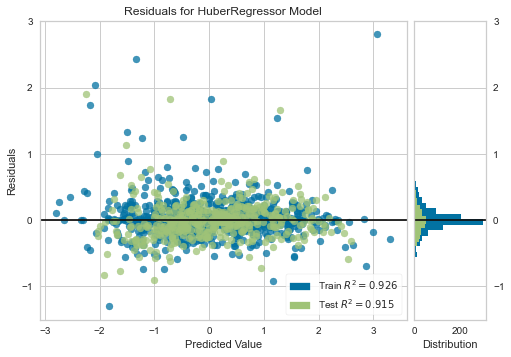

In [52]:
plot_model(huber, plot = 'residuals')

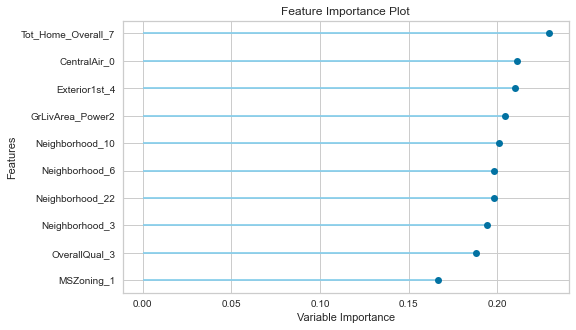

In [54]:
plot_model(huber, plot = 'feature')

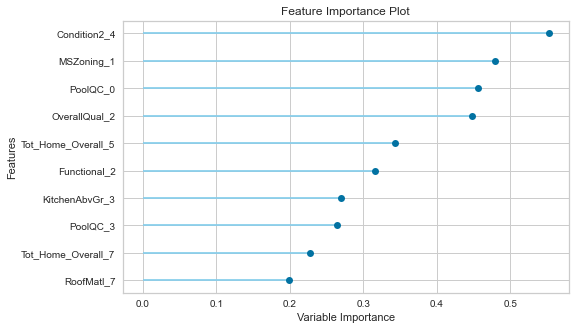

In [60]:
plot_model(ridge, plot = 'feature')

In [55]:
predict_model(blend_all);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,13310.8018,4.228048e+08,20562.2171,0.9334,0.1063,0.0743


In [56]:
final_blender = finalize_model(blend_all)
print(final_blender)

VotingRegressor(estimators=[('Huber Regressor_0',
                             HuberRegressor(alpha=0.1097, epsilon=1.1,
                                            fit_intercept=True, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('CatBoost Regressor_1',
                             <catboost.core.CatBoostRegressor object at 0x00000254D5C5E608>),
                            ('Ridge_2',
                             Ridge(alpha=0.936, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=True,
                                   random_state=123, solver='auto',
                                   tol=0.001)),
                            ('Bayesian Ridge_3',
                             BayesianRidge(alpha_1=1e-07, alpha_2=0.2,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,

In [57]:
predictions = predict_model(final_blender, data = test)
predictions.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,HasGarage_0,HasGarage_1,old_house_0,old_house_1,Label
0,1461,80.0,11622.0,5,5,1961,1961,0.0,468.0,144.0,...,0,0,0,1,0,0,1,0,1,123170.5257
1,1462,81.0,14267.0,6,5,1958,1958,108.0,923.0,0.0,...,0,0,0,1,0,0,1,0,1,162130.1789
2,1463,74.0,13830.0,5,4,1997,1998,0.0,791.0,0.0,...,0,0,0,1,0,0,1,1,0,191140.1960
3,1464,78.0,9978.0,6,5,1998,1998,20.0,602.0,0.0,...,0,0,0,1,0,0,1,1,0,200565.8768
4,1465,43.0,5005.0,8,4,1992,1992,0.0,263.0,0.0,...,0,0,0,1,0,0,1,1,0,191714.0441
